### Problems need to be comfired

1. How to generate M? 
2. Given output of conv4_3 layer, how to generate M_hat?
3. Does selected feature maps indexes are fixed arcoss all imgs in a video?


probel: sel_cnn loss can not decrease
idea1: change scale factor of the mask
idea2: change data

In [1]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

import scipy.stats as st

import sys

show = skimage.io.imshow
%matplotlib inline

In [2]:
def porcess_img(img):
    """
    Porcessing image required by vgg16
    Returns:
        image of shape [224, 224, 3]
        [1, height, width, depth]
    """
    # load image
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    
    # conert to color image if its a grey one
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
    assert len(img.shape) == 3
    
    # crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy : yy + short_edge, xx : xx + short_edge]

    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (224, 224))
    return resized_img.reshape((1, 224, 224, 3))

In [3]:
# returns the top1 string
def print_prob(prob):
	synset = [l.strip() for l in open('synset.txt').readlines()]
	#print prob
	print( "prob shape", prob.shape)
	pred = np.argsort(prob)[::-1]

	# Get top1 label
	top1 = synset[pred[0]]
	print( "Top1: ", top1)
	# Get top5 label
	top5 = [synset[pred[i]] for i in range(5)]
	print( "Top5: ", top5)
	return top1

In [4]:
# draw on img
def img_with_bbox(img_origin, gt_1):
    img =np.copy(img_origin)
    w, h = gt_1[2:]
    tl_x, tl_y = gt_1[:2]
    tr_x, tr_y = tl_x + w, tl_y 
    dl_x, dl_y = tl_x, tl_y + h
    dr_x, dr_y = tl_x + w, tl_y +h

    rr1, cc1 = skimage.draw.line( tl_y,tl_x, tr_y, tr_x)
    rr2, cc2 = skimage.draw.line( tl_y,tl_x, dl_y, dl_x)
    rr3, cc3 = skimage.draw.line( dr_y,dr_x, tr_y, tr_x)
    rr4, cc4 = skimage.draw.line( dr_y,dr_x, dl_y, dl_x)
    img[rr1, cc1, :] = 1
    img[rr2, cc2, :] = 1
    img[rr3, cc3, :] = 1
    img[rr4, cc4, :] = 1
    return img


In [5]:
def extract_roi(img, gt, roi_size):
    """Extract ROI from img with target centered.
    
    Returns:
        roi: tensor,
        roi_pos: list of params for roi_pos, [tlx, tly, h, w]
    
    """
    assert max(gt[2:]) <= roi_size
    
    # Construct an padded img first.
    convas = np.zeros([img.shape[0]+2*roi_size, img.shape[1]+2*roi_size, 3])
    convas[roi_size:-roi_size, roi_size:-roi_size] = img

    # Compute target center location in convas
    tlx_convas, tly_convas = gt[0]+roi_size, gt[1]+roi_size
    cx = tlx_convas + int(0.5 * gt[2])
    cy = tly_convas + int(0.5 * gt[3])
    
    # Crop an roi_size region centered at cx, cy
    half = roi_size // 2
    roi = convas[cy-half:cy+half, cx-half:cx+half, :]
    
    # compute new target pos in roi window
    new_cx, new_cy = [int(i*0.5) for i in roi.shape[:-1]]
    new_x = new_cx - gt[2] // 2
    new_y = new_cx - gt[3] // 2
    
    return roi, [new_x, new_y, gt[2], gt[3]]

    

In [6]:
def gen_mask_bak(img_size, pos):
    """
    Generates 2-D gaussian mask with variance proportion
    target's region
    
    Args:
        img_size: 
        pos:
    Returns:
        masked_img:
    """
    # sigma is consistence with the paper
    kernly, kernlx = pos[2:]
    nsig =  min(pos[2:]) / 3 #kernly / kernlx #
    
    # Constructs 2D gaussian 
    intervalx = (2*nsig+1.)/(kernlx)
    x = np.linspace(-nsig-intervalx/2., nsig+intervalx/2., kernlx+1)
    kern1dx = np.diff(st.norm.cdf(x))
    
    intervaly = (2*nsig+1.)/(kernly)
    y = np.linspace(-nsig-intervaly/2., nsig+intervaly/2., kernly+1)
    kern1dy = np.diff(st.norm.cdf(y))
    
    # Normalize
    kernel_raw = np.sqrt(np.outer(kern1dx, kern1dy))
    kernel = kernel_raw/kernel_raw.sum()
    
    print(kernel.shape, img_size)
    # Plcace into an img_size convas
    img = np.zeros(img_size)
    img[pos[1]: pos[1]+pos[3], pos[0]: pos[0]+pos[2]] = kernel
    return img
    
     

In [7]:
def matlab_style_gauss2D(shape=(6,6),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h / h.max()
    return h

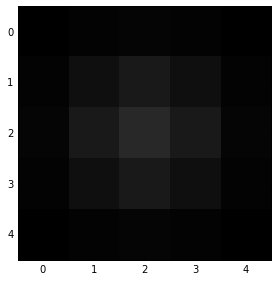

In [8]:
show(np.array([[ 0.002969,  0.013306,  0.021938,  0.013306,  0.002969],
       [ 0.013306,  0.059634,  0.09832 ,  0.059634,  0.013306],
       [ 0.021938,  0.09832 ,  0.162103,  0.09832 ,  0.021938],
       [ 0.013306,  0.059634,  0.09832 ,  0.059634,  0.013306],
       [ 0.002969,  0.013306,  0.021938,  0.013306,  0.002969]]))

In [ ]:
matlab_style_gauss2D(shape=(10,10))

In [ ]:
nsig = 9.5
kernlx = 20
# Constructs 2D gaussian 
intervalx = (2*nsig+1.)/(kernlx)
x = np.linspace(-nsig-intervalx/2., nsig+intervalx/2., kernlx+1)

In [ ]:
x

In [ ]:
plt.plot(x)

In [ ]:
cdf = st.norm.cdf(x)

In [ ]:
plt.plot(np.diff(cdf))

In [37]:
img_origin.shape

(240, 352, 3)

In [40]:
from scipy.misc import imresize
ans = imresize(img_origin[...,0], (452,352), interp='bicubic')

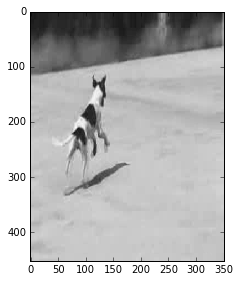

In [41]:
show(ans)

In [9]:
def gen_mask(img_size, pos_gt ):
    img = np.zeros((14,14))
    c = 14 /2
    img[c-3:c+3, c-3:c+3] = matlab_style_gauss2D(shape=(6,6),sigma=48/3)
    
    return img
    
     

In [10]:
def _variable_on_cpu(name, shape, initializer):
	"""Helper to create a Variable stored on CPU memory.

	Args:
	  name: name of the variable
	  shape: list of ints
	  initializer: initializer for Variable

	Returns:
	  Variable Tensor
	"""
	dtype = tf.float32
	with tf.device('/cpu:0'):
		variable = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
	return variable

def variable_with_weight_decay(name, shape, stddev=1e-3, wd=None):
	"""Helper to create an initialized Variable with weight decay

	Args:
		name: name of the variable
		shape: list of ints
		stddev: float, standard deviation of a truncated Gaussian for initial value
		wd: add L2loss weight decay multiplied by this float. If None, weight decay 
				is not added to this variable

	Returns:
		Variable: Tensor
	"""
	dtype = tf.float32
	variable = _variable_on_cpu(
							name, 
							shape,
							initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
	if wd is not None:
		weight_decay = tf.mul(tf.nn.l2_loss(variable), wd, name='weight_loss')
		tf.add_to_collection('losses', weight_decay)
	return variable

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


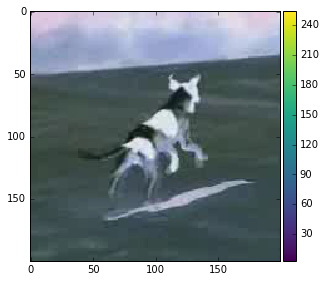

In [11]:
img_path = 'data/Dog/img/0001.jpg'

# read bbox from file 
gt_fn = 'data/Dog/groundtruth_rect.txt'
f = open(gt_fn, 'r')
lines = f.readlines()

# gt_list is a list of list locations
gt_list = [[int(p) for p in i[:-1].split('\t')] 
                   for i in lines]

# parper inputs 
gt_1 = gt_list[0]
img_origin = skimage.io.imread(img_path)

roi, pos = extract_roi(img_origin, gt_1, 200)
skimage.io.imshow(roi)

In [ ]:
pos

In [ ]:
show(img_origin)

In [ ]:
skimage.io.imshow(img_with_bbox(roi, pos))

/home/xlws/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


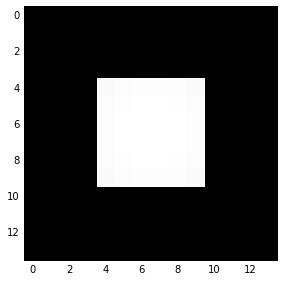

In [12]:
gt_M = gen_mask(roi.shape[:-1], pos)
show(gt_M)

In [ ]:
gt_M

In [13]:
# see how vgg predicts
vgg16_model_path = 'vgg16.tfmodel'
img_porcessed = porcess_img(roi)
with open(vgg16_model_path, mode='rb') as f:
    fileContent = f.read()
    
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

images = tf.placeholder("float", [None, 224, 224, 3])
tf.import_graph_def(graph_def, input_map={ "images": images })

graph = tf.get_default_graph()

sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [ ]:
show(img_porcessed[0,...])

In [14]:
feed_dict = { images: img_porcessed }
prob_tensor = graph.get_tensor_by_name("import/prob:0")
prob = sess.run(prob_tensor, feed_dict=feed_dict)
print_prob(prob[0])
sess.close()

prob shape (1000,)
Top1:  n02087046 toy terrier
Top5:  ['n02087046 toy terrier', 'n02091831 Saluki, gazelle hound', 'n02090622 borzoi, Russian wolfhound', 'n02106166 Border collie', 'n02091134 whippet']


In [15]:
## Build sel-CNN network
# retrive vgg16 layers
conv4_3 = graph.get_tensor_by_name('import/conv4_3/Relu:0')#Conv2D:0')  #Relu:0')#
conv5_3 = graph.get_tensor_by_name('import/conv5_3/Relu:0')#Conv2D:0') #Relu:0')
print(conv4_3)
print(conv5_3)

Tensor("import/conv4_3/Relu:0", shape=(?, 28, 28, 512), dtype=float32)
Tensor("import/conv5_3/Relu:0", shape=(?, 14, 14, 512), dtype=float32)


In [ ]:
# visual conv layer
with tf.Session() as sess:
    res4, res5 = sess.run([conv4_3, conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [16]:
# sel-CNN network 
dropout_layer = tf.nn.dropout(conv5_3, 0.3)
kernel_size = [3, 3, 512, 1]

conv_k = variable_with_weight_decay('conv4_3_k', kernel_size, wd = 1.0)
sel_conv = tf.nn.conv2d(dropout_layer, conv_k, [1,1,1,1], 'SAME')


In [17]:
sel_conv

<tf.Tensor 'Conv2D:0' shape=(?, 14, 14, 1) dtype=float32>

In [18]:
bias = _variable_on_cpu('biases', [1], tf.constant_initializer(0.1))
sel_conv_bias = tf.nn.bias_add(sel_conv, bias)

In [19]:
pre_M_tensor = sel_conv_bias# - tf.reduce_mean(sel_conv_bias)

In [ ]:
# Bilinear interpolates the sel-conv
pre_M_tensor = tf.image.resize_bilinear(sel_conv_bias, roi.shape[:-1])

# Subtract mean value
mean = tf.reduce_mean(pre_M_tensor)
#pre_M_tensor -= mean

In [20]:
gt_M_tensor = tf.constant(gt_M.reshape((1,gt_M.shape[0], gt_M.shape[1], 1)), dtype=tf.float32)# + mean

In [21]:

sess = tf.Session()
sess.run(tf.initialize_all_variables())

pre_M, gt_M = sess.run([pre_M_tensor, gt_M_tensor], feed_dict=feed_dict)

In [22]:
pre_M.mean()

0.19189668

In [23]:
gt_M.mean()

0.18177445

In [ ]:
show(pre_M[0,:,:,0])

In [ ]:
#gt_M_tensor = tf.constant(gt_M.reshape((1,gt_M.shape[0], gt_M.shape[1], 1)), dtype=tf.float32)
#rms_loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(gt_M_tensor, pre_M_tensor))))

In [24]:
rms_loss = tf.reduce_mean(tf.square(tf.sub(gt_M_tensor, pre_M_tensor)))
tf.add_to_collection('losses', rms_loss)

In [25]:
tf.get_collection(tf.GraphKeys.LOSSES)

[<tf.Tensor 'weight_loss:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean:0' shape=() dtype=float32>]

In [26]:
losses = tf.add_n(tf.get_collection(tf.GraphKeys.LOSSES), 'total_losses')

In [27]:
losses

<tf.Tensor 'total_losses:0' shape=() dtype=float32>

In [28]:
lr = 1e-9
optimizer = tf.train.GradientDescentOptimizer(lr)
train_op = optimizer.minimize(losses)

In [29]:
import matplotlib.pyplot as plt

loss:  0.56892
loss:  0.483257
loss:  0.448229
loss:  0.547702
loss:  0.541852
loss:  0.45585
loss:  0.52261
loss:  0.506755
loss:  0.575646
loss:  0.577756
loss:  0.651562
loss:  0.412532
loss:  0.636941
loss:  0.507145
loss:  0.57504
loss:  0.46968
loss:  0.513699
loss:  0.570384
loss:  0.363339
loss:  0.53212
loss:  0.529541
loss:  0.482249
loss:  0.500833
loss:  0.562048
loss:  0.49861
loss:  0.539794
loss:  0.474479
loss:  0.486919
loss:  0.477174
loss:  0.5285
loss:  0.491358
loss:  0.652679
loss:  0.442541
loss:  0.412065
loss:  0.563198
loss:  0.44825
loss:  0.541659
loss:  0.455202
loss:  0.504106
loss:  0.469974
loss:  0.5232
loss:  0.511372
loss:  0.562269
loss:  0.446661
loss:  0.628418
loss:  0.70351
loss:  0.575051
loss:  0.512152
loss:  0.441886
loss:  0.451699
loss:  0.453947
loss:  0.701234
loss:  0.506479
loss:  0.468124
loss:  0.40343
loss:  0.535811
loss:  0.434161
loss:  0.396358
loss:  0.528087
loss:  0.498367
loss:  0.513078
loss:  0.552767
loss:  0.415411
loss: 

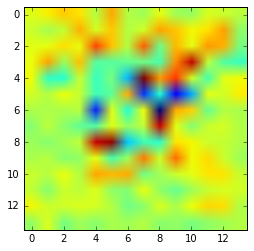

In [34]:
iter_sel = 2000
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for _ in range(iter_sel):
    # update weights
    _, total_loss, pre_M = sess.run([train_op, losses, pre_M_tensor], feed_dict=feed_dict)
    
    # visualize predicted heat map
    sys.stdout.flush()
    print('loss: ',total_loss)
    plt.imshow(pre_M[0,:,:,0])

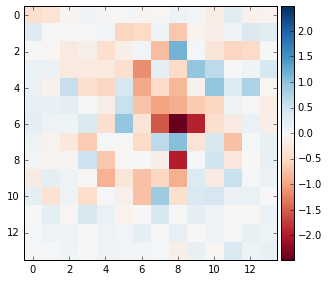

In [31]:
show(pre_M[0,:,:,0])

In [32]:
gt_M.shape

(1, 14, 14, 1)

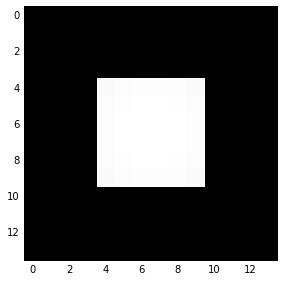

In [33]:
show(gt_M[0,:,:,0])

In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    pre_M = sess.run(pre_M_tensor, feed_dict=feed_dict)

In [ ]:
show(pre_M[0,:,:,0])

In [ ]:
# train sel_cnn
pre_M.shape

In [ ]:
tf.get_collection(tf.GraphKeys.VARIABLES)